### Cluster after Minhashing 

In [ ]:
#libraries 
import pandas as pd 
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
import re
import hdbscan
from pathlib import Path
import umap

In [ ]:
#get dataset including minhashing results
path = Path(r"C:\Users\marta\My drive (marta.infante.baiao@gmail.com) (1)\DTU\Computational Tools\minhashing_results_subset.csv")
df = pd.read_csv(path)
df.shape
df.columns

Index(['signature', 'rating'], dtype='object')

In [3]:
#Prepare data for clustering:
#Convert integer to float
df['signature'] = df['signature'].apply(
    lambda s: np.array(re.findall(r'-?\d+', str(s)), dtype=int)
)

#Transform  df['signature'] in lists of length 100 
X = np.array(df['signature'].tolist())
y = df['rating'].values  # true labels

/var/folders/17/4ypkwf497x10dw9zl6kjtsg80000gn/T/ipykernel_22645/2156793347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signature'] = df['signature'].apply(


In [4]:
#check X and y shape 
print(X.shape)
print(y.shape)

(10000, 100)
(10000,)


## CLUSTERING 

# K-MEANS 

In [ ]:
#RUN K-MEANS
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
Kmeans_clusters = kmeans.fit_predict(X)

#check clustering results 
Kmeans_clusters.shape
print(Kmeans_clusters[70:75])
print(np.unique(Kmeans_clusters))


### EVALUATION KMEANS

In [21]:
clusters=Kmeans_clusters+1  # shift to make clusters start at 1

In [67]:
#EVALUATION using DAVIES-BOULDIN INDEX
def DB(X, clusters):
    db = davies_bouldin_score(X, clusters)
    return db

#Evaluate K-Means
db_Kmeans = DB(X, Kmeans_clusters)
print(f"Davies-Bouldin Index (DB): {db_Kmeans:.4f}")
    

Davies-Bouldin Index (DB): 2.9647


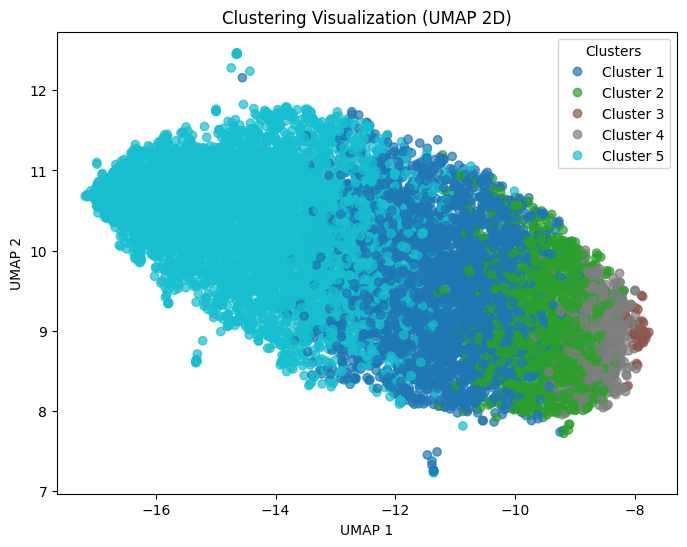

In [ ]:
#VISUALIZATION of CLUSTERS
# Reduce to 2D using UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X2_umap = umap_model.fit_transform(X)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X2_umap[:, 0], X2_umap[:, 1],
                      c=clusters, cmap='tab10', alpha=0.7)

# Legend for cluster IDs
handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in np.unique(clusters)], 
           title="Clusters")

plt.title("Clustering Visualization (UMAP 2D)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()



rating    1.0   2.0   3.0    4.0    5.0
cluster                                
1         303   154   329    835   3697
2        3670  3137  5002  11114  28166
3          38    12    21     42    242
4         883   532   884   2371   9666
5        2130  1406  2085   4865  18416


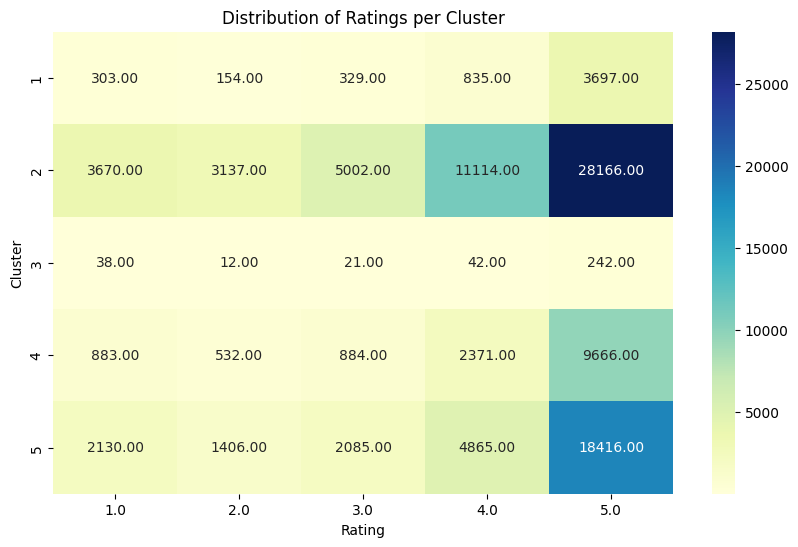

rating        1.0       2.0       3.0       4.0       5.0
cluster                                                  
1        0.043138  0.029384  0.039539  0.043429  0.061425
2        0.522494  0.598550  0.601130  0.578041  0.467975
3        0.005410  0.002290  0.002524  0.002184  0.004021
4        0.125712  0.101507  0.106237  0.123316  0.160599
5        0.303246  0.268269  0.250571  0.253030  0.305980


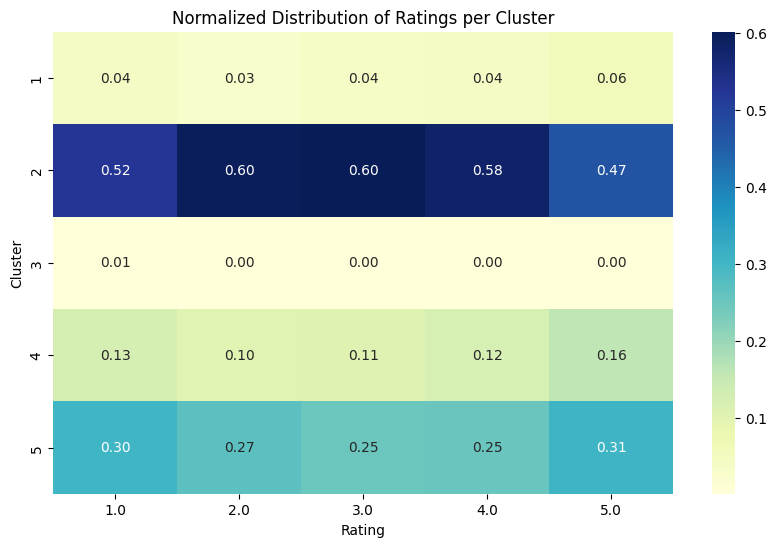

In [ ]:
#ANALYSIS OF CLUSTERS WITH RESPECT TO RATINGS

# Create dataframe containing ratings and cluster assignments
df_results = pd.DataFrame({
    'rating': y,
    'cluster': clusters
})

#Table showing distribution of ratings per cluster
cluster_summary = pd.crosstab(df_results['cluster'], df_results['rating'])
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()

#Normalize the values to take into account the size of each group of rating 
for i in range(1,6):
    cluster_summary[i] = cluster_summary[i] / cluster_summary[i].sum()
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Normalized Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()


## UMAP + HDBSCAN

In [ ]:
umap_model = umap.UMAP(
    n_neighbors=30,      # controls local vs global structure
    min_dist=0.0,        # tighter clusters
    n_components=15,      
    metric='euclidean',
    random_state=42
)

X_umap = umap_model.fit_transform(X)



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## HDBSCAN

In [ ]:
#Run HDBSCAN
HDBSCAN = hdbscan.HDBSCAN(
    min_cluster_size=500,
    min_samples=500
)
Hdbscan_clusters = HDBSCAN.fit_predict(X_umap)

#check clustering results 
Hdbscan_clusters.shape
print(Dbscan_clusters[70:75])
print(np.unique(Dbscan_clusters))

### EVALUATION DBSCAN

In [ ]:
clusters=Hdbscan_clusters+1 

In [ ]:
#EVALUATION using DAVIES-BOULDIN INDEX
def DB(X, clusters):
    db = davies_bouldin_score(X, clusters)
    return db


#Evaluate HDBSCAN
db_HDBscan = DB(X, labels)
print(f"Davies-Bouldin Index (DB) for HDBSCAN: {db_HDBscan:.4f}")

Davies-Bouldin Index (DB) for DBSCAN: 2.3151
Davies-Bouldin Index (DB) for DBSCAN: 3.9086


In [ ]:
#VISUALIZATION of CLUSTERS
# Reduce to 2D using UMAP
plt.figure(figsize=(8,6))
scatter = plt.scatter(X2_umap[:, 0], X2_umap[:, 1],
                      c=clusters, cmap='tab10', alpha=0.7)

# Legend for cluster IDs
handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in np.unique(clusters)], 
           title="Clusters")

plt.title("Clustering Visualization (UMAP 2D)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

rating   1.0  2.0  3.0   4.0   5.0
cluster                           
0          0    0    0     8     7
1          2    0    0     5     9
2        726  574  866  2055  5748


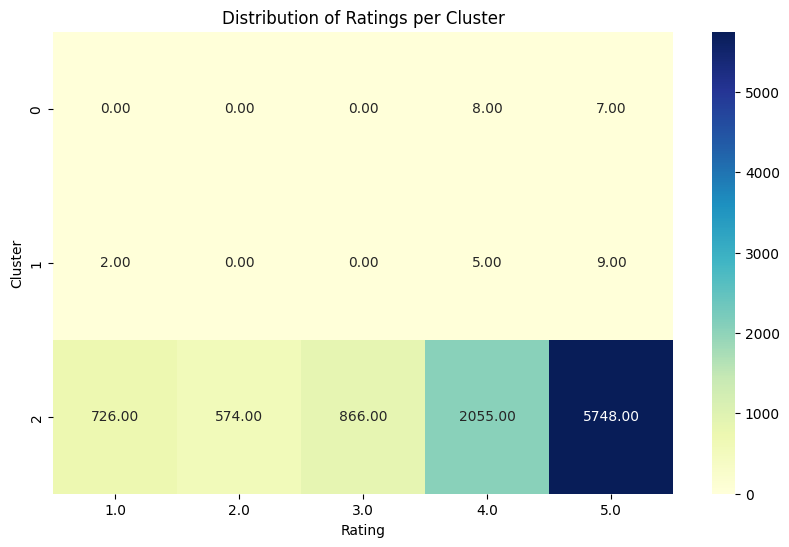

rating        1.0  2.0  3.0       4.0       5.0
cluster                                        
0        0.000000  0.0  0.0  0.003868  0.001214
1        0.002747  0.0  0.0  0.002418  0.001561
2        0.997253  1.0  1.0  0.993714  0.997224


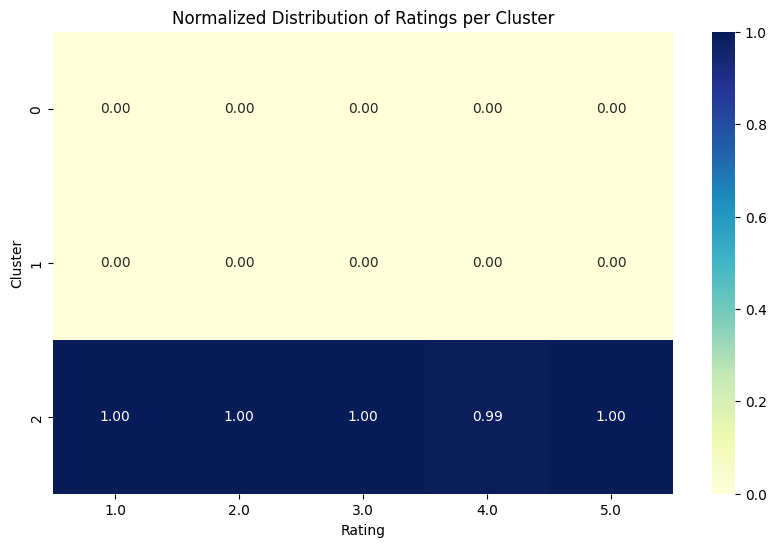

In [ ]:
#ANALYSIS OF CLUSTERS WITH RESPECT TO RATINGS
# Create dataframe containing ratings and cluster assignments
df_results = pd.DataFrame({
    'rating': y,
    'cluster': clusters
})

#Table showing distribution of ratings per cluster
cluster_summary = pd.crosstab(df_results['cluster'], df_results['rating'])
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()

#Normalize the values to take into account the size of each group of rating 
for i in range(1,6):
    cluster_summary[i] = cluster_summary[i] / cluster_summary[i].sum()
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Normalized Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()